# TUR-1060: Incremental Sales Analysis and Modelling: Data analysis


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
import warnings

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

sys.path.insert(1, '/home/jovyan')
sys.path.insert(2, sys.path[0] + '/src')
os.environ["GOOGLE_CLOUD_PROJECT"] = 'wx-bq-poc'
warnings.filterwarnings('ignore')

import util
PROJECT = 'wx-bq-poc'

from scipy import stats

In [4]:
from matplotlib import gridspec

def calplot(df, title, bins, limit=1000):
    _df = df[['pred', 'target']].sort_values(by='pred')
    _df = pd.cut(_df['pred'], bins)
    _df = pd.DataFrame({'x': _df.apply(lambda x: x.mid)})
    _df = df.merge(_df, left_index=True, right_index=True)
    _df = _df.groupby(by='x').agg({'target': 'mean', 'pred': 'mean'}).reset_index()
    _df = _df.dropna(how='any')
        
    fig = plt.figure(figsize=(10,10))
    spec = gridspec.GridSpec(
        ncols=1, nrows=2, height_ratios=[3, 1]
    )
    
    ax0 = fig.add_subplot(spec[0])
    ax0.set_title(title)
    ax0.grid()
    ax0.plot(np.arange(-limit,limit), np.arange(-limit,limit), '--', color='k')
    ax0.plot(_df['pred'], _df['target'])
    ax0.set_xlim(-limit, limit)
    ax0.set_ylim(-limit, limit)
    ax0.set_ylabel('true')

    ax1 = fig.add_subplot(spec[1], sharex = ax0)
    ax1.hist(df['pred'], bins=bins, edgecolor='w')
    ax1.grid()
    ax1.set_yscale('log')
    ax1.set_xlabel('pred')
    ax1.set_ylabel('volume')

    plt.show()
    
#     return _df

### Checking for SS1 distribution of incremental sales

In [4]:
sql = ''' 
    SELECT crn, ref_dt, weekly_inc_sales
    FROM  `gcp-wow-rwds-ai-mmm-super-dev.DEV_MMM.MMM_FINAL_FEATURES_CAMP_TUR1060` 
    WHERE offer_type = 'SS1' 
        AND ref_dt <= '2021-02-28'
        AND Model = 'R'
'''

df = util.sql2df(PROJECT, sql)

bins = 200
plt.figure(figsize=(25,10))
plt.hist(df['weekly_inc_sales'], bins=bins, range=(-1000, 1000), histtype='step')
plt.title("Weekly inc sales distribution")
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

### Prediction without model

In [6]:
y_true = df['weekly_inc_sales'].values
y_pred = df['weekly_inc_sales'].mean()

rmse = np.sqrt(((y_true - y_pred) ** 2).mean())
print(rmse)

nan


### Prediction of inc sales

In [7]:
sql = ''' 
    SELECT crn, ref_dt, weekly_inc_sales
    FROM  `gcp-wow-rwds-ai-mmm-super-dev.DEV_MMM.MMM_FINAL_FEATURES_CAMP_TUR1060` 
    WHERE offer_type = 'SS1' 
        AND ref_dt BETWEEN '2021-06-06' AND '2021-07-18'
'''

ss1_true_df = util.sql2df(PROJECT, sql)

y_true = ss1_true_df['weekly_inc_sales'].values
y_pred = ss1_true_df['weekly_inc_sales'].mean()
rmse = np.sqrt(((y_true - y_pred) ** 2).mean())
print(rmse)

20.528770203014457


### Old (Existing) model

RMSE = 22.45943259636535
Pearson R = (0.038799902149078, 0.0)


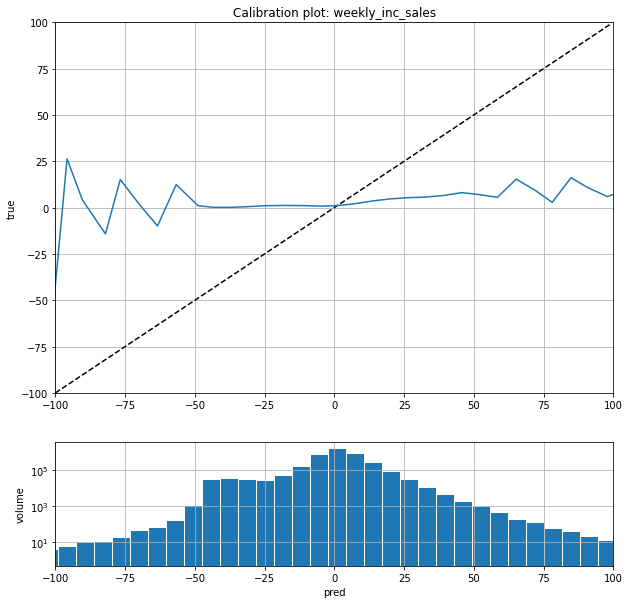

In [9]:
ss1_old_df = util.pq2df('gs://wx-personal/denny/direct_inc_sales_model/SS1_old/scoring/output/2021-09-09/processed_data/')
base_ss1_old_df = util.pq2df('gs://wx-personal/denny/direct_inc_sales_model/base_SS1_old/scoring/output/2021-09-09/processed_data')
ss1_old_df = ss1_old_df[['crn', 'ref_dt', 'score']]
base_ss1_old_df = base_ss1_old_df[['crn', 'ref_dt', 'score']]
base_ss1_old_df.rename(columns={'score': 'base_score'}, inplace=True)

ss1_old_joined_df = ss1_old_df.merge(
    base_ss1_old_df, how='inner', left_on=['crn', 'ref_dt'], right_on=['crn', 'ref_dt']
).merge(
    ss1_true_df, how = 'inner', left_on=['crn', 'ref_dt'], right_on=['crn', 'ref_dt']
)
ss1_old_joined_df['pred_weekly_inc_sales'] = ss1_old_joined_df['score'] - ss1_old_joined_df['base_score']
ss1_old_joined_df.rename(columns={'pred_weekly_inc_sales': 'pred', 'weekly_inc_sales': 'target'}, inplace=True)

y_true = ss1_old_joined_df['target'].values
y_pred = ss1_old_joined_df['pred'].values
rmse = np.sqrt(((y_true - y_pred) ** 2).mean())
print(f'RMSE = {rmse}')
print(f'Pearson R = {stats.pearsonr(y_true, y_pred)}')
y_pred_old = y_pred # store

calplot(ss1_old_joined_df, 'Calibration plot: weekly_inc_sales', 50, limit=100)

##### Detour: Incremental sales correlation - MMM vs Safari's

(0.7957609842639213, 0.005900992303703266)


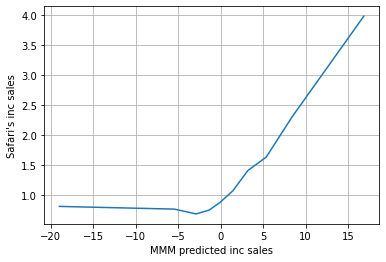

In [15]:
ss1_old_joined_df['decile'] = pd.qcut(ss1_old_joined_df['pred'],10)
test_df = ss1_old_joined_df.groupby('decile').aggregate({'target':'mean', 'pred':'mean'})
print(f'Pearson R = {stats.pearsonr(test_df['pred'], test_df['target'])}')
plt.plot(test_df['pred'], test_df['target'])
plt.ylabel("Safari's inc sales")
plt.xlabel("MMM predicted inc sales")
plt.grid()
plt.show()


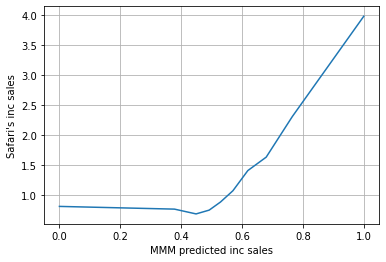

In [16]:
test_df['pred'] = (test_df['pred'] - test_df['pred'].min()) / (test_df['pred'].max() - test_df['pred'].min())
plt.plot(test_df['pred'], test_df['target'])
plt.ylabel("Safari's inc sales")
plt.xlabel("MMM predicted inc sales")
plt.grid()
plt.show()

(0.8534929478753489, 0.0016824497814245673)


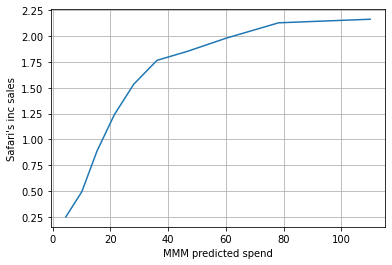

In [18]:
ss1_old_joined_df['decile'] = pd.qcut(ss1_old_joined_df['score'], 10)
test_df = ss1_old_joined_df.groupby('decile').aggregate({'target':'mean', 'score':'mean'})
print(f'Pearson R = {stats.pearsonr(test_df['score'], test_df['target'])}')
plt.plot(test_df['score'], test_df['target'])
plt.ylabel("Safari's inc sales")
plt.xlabel("MMM predicted spend")
plt.grid()
plt.show()

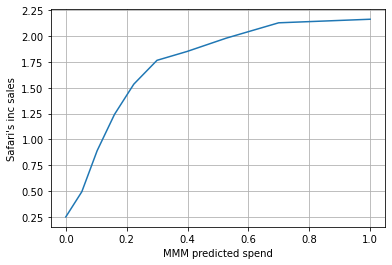

In [19]:
test_df['score'] = (test_df['score'] - test_df['score'].min()) / (test_df['score'].max() - test_df['score'].min())
plt.plot(test_df['score'], test_df['target'])
plt.ylabel("Safari's inc sales")
plt.xlabel("MMM predicted spend")
plt.grid()
plt.show()

### Incremental sales: more checks

In [20]:
sql = ''' 
    SELECT crn, ref_dt, weekly_inc_sales, Model as model
    FROM  `gcp-wow-rwds-ai-mmm-super-dev.DEV_MMM.MMM_FINAL_FEATURES_CAMP_TUR1060` 
    WHERE offer_type = 'SS1' 
        AND ref_dt >= '2021-06-01'
'''

model_df = util.sql2df(PROJECT, sql)
m_df = model_df[model_df.model=='M']
r_df = model_df[model_df.model=='R']
print(m_df['weekly_inc_sales'].mean(), m_df['weekly_inc_sales'].count())
print(r_df['weekly_inc_sales'].mean(), r_df['weekly_inc_sales'].count())

1.4732029905494672 4037582
0.8594194621661124 309393


### Prediction of inc sales based on new model

In [22]:
ss1_new_df = util.pq2df('gs://wx-personal/denny/direct_inc_sales_model/SS1_aliu_new/scoring/output/2021-09-18/processed_data')

ss1_new_joined_df = ss1_true_df.merge(
    ss1_new_df[['crn', 'ref_dt', 'score']], how = 'inner', left_on=['crn', 'ref_dt'], right_on=['crn', 'ref_dt']
)
ss1_new_joined_df.rename(columns={'score': 'pred', 'weekly_inc_sales': 'target'}, inplace=True)

y_true = ss1_new_joined_df['target'].values
y_pred = ss1_new_joined_df['pred'].values

rmse = np.sqrt(((y_true - y_pred) ** 2).mean())
print(f'RMSE = {rmse}')
print(f'Pearson R = {stats.pearsonr(y_true, y_pred)}')

y_pred_new = y_pred

calplot(ss1_new_joined_df, 'Calibration plot: weekly_inc_sales', 50, limit=100)

### Zero inflated

In [26]:
zir_df = util.pq2df('gs://wx-personal/denny/direct_inc_sales_model/SS1_aliu_new_zir/scoring/output/2021-09-18/processed_data')
zic_df = util.pq2df('gs://wx-personal/denny/direct_inc_sales_model/SS1_aliu_new_zic/scoring/output/2021-09-18/processed_data')

In [27]:
zic_joined_df = zic_df.merge(
    ss1_true_df, how = 'inner', left_on=['crn', 'ref_dt'], right_on=['crn', 'ref_dt']
)
zic_joined_df.rename(columns={'score': 'pred', 'weekly_inc_sales': 'target'}, inplace=True)
zic_joined_df = zic_joined_df[['crn', 'ref_dt','pred', 'target']]

zic_joined_df['target'] = zic_joined_df['target'].apply(lambda x: 0 if x == 0 else 1)

from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(zic_joined_df['target'], zic_joined_df['pred'])
roc_auc_score(zic_joined_df['target'], zic_joined_df['pred'])

roc_df = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 't':thresholds})
roc_df['fn'] = np.sqrt((1-fpr)**2+tpr**2)
threshold = roc_df[roc_df['fn'] == roc_df['fn'].max()]['t'].values[0]

In [31]:
joined_df = ss1_true_df.merge(
    zic_df[['crn', 'ref_dt', 'score']], how = 'inner', left_on=['crn', 'ref_dt'], right_on=['crn', 'ref_dt']
).merge(
    zir_df[['crn', 'ref_dt', 'score']], how = 'inner', left_on=['crn', 'ref_dt'], right_on=['crn', 'ref_dt']
)

def combine_score(row):
    if row['score_x'] <= threshold:
        return 0
    else:
        return row['score_y']

joined_df['score'] = joined_df.apply(combine_score, axis=1)
joined_df.rename(columns={'weekly_inc_sales': 'target', 'score': 'pred'}, inplace=True)

calplot(joined_df, 'Calibration plot: weekly_inc_sales', 50, limit=100)

In [34]:
y_true = joined_df['target'].values
y_pred = joined_df['pred'].values

rmse = np.sqrt(((y_true - y_pred) ** 2).mean())
print(f'RMSE = {rmse}')
print(f'Pearson R = {stats.pearsonr(y_true, y_pred)}')

23.622170056318204
(0.06960341068705032, 0.0)


### Comparisons

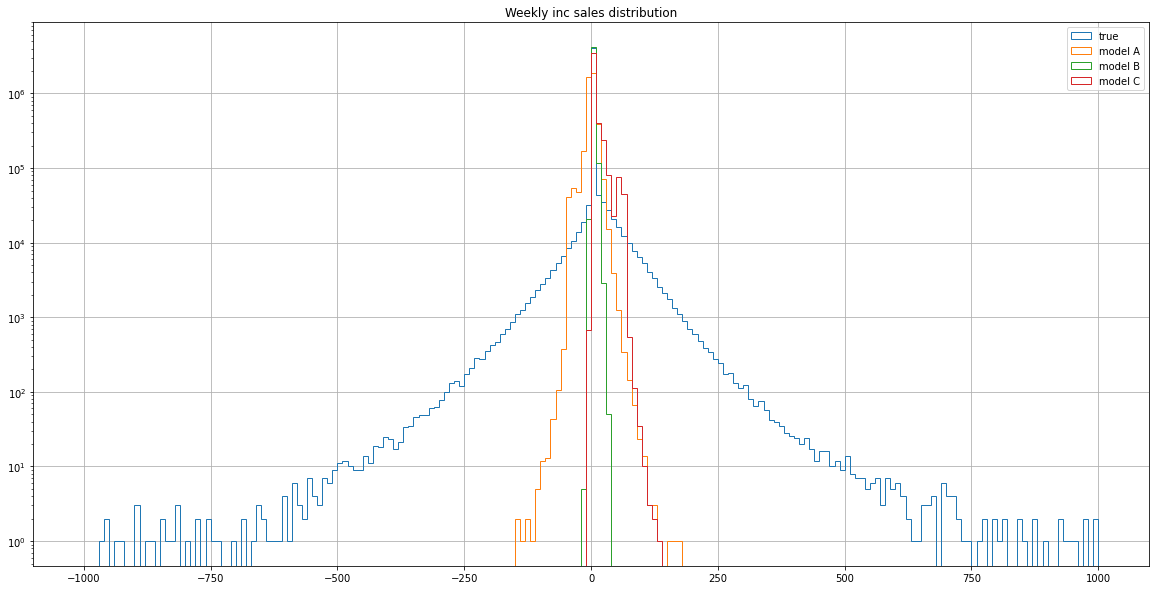

In [35]:
bins = 200
plt.figure(figsize=(20,10))
plt.hist(y_true, bins=bins, range=(-1000, 1000), histtype='step', label='true')
plt.hist(y_pred_old, bins=bins, range=(-1000, 1000), histtype='step', label='model A')
plt.hist(y_pred_new, bins=bins, range=(-1000, 1000), histtype='step', label='model B')
plt.hist(y_pred, bins=bins, range=(-1000, 1000), histtype='step', label='model C')
plt.title("Weekly inc sales distribution")
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

### Single campaign analysis (attributed to SS1 only)

RMSE = 19.522548629121705
Pearson R = (0.027081859048698028, 6.006513560753982e-05)


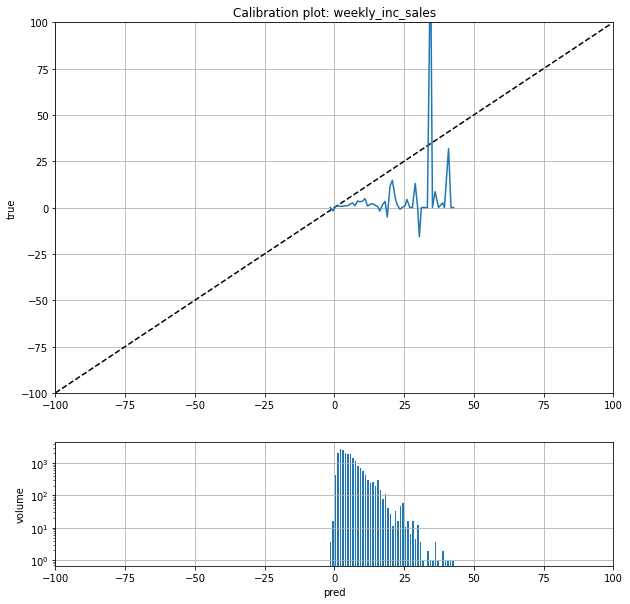

In [8]:
ss1_new_df = util.pq2df('gs://wx-personal/denny/direct_inc_sales_model/SS1_single_new/scoring/output/2021-09-19/processed_data')

ss1_new_joined_df = ss1_true_df.merge(
    ss1_new_df[['crn', 'ref_dt', 'score']], how = 'inner', left_on=['crn', 'ref_dt'], right_on=['crn', 'ref_dt']
)
ss1_new_joined_df.rename(columns={'score': 'pred', 'weekly_inc_sales': 'target'}, inplace=True)

y_true = ss1_new_joined_df['target'].values
y_pred = ss1_new_joined_df['pred'].values

rmse = np.sqrt(((y_true - y_pred) ** 2).mean())
print(f'RMSE = {rmse}')
print(f'Pearson R = {stats.pearsonr(y_true, y_pred)}')

y_pred_new = y_pred

calplot(ss1_new_joined_df, 'Calibration plot: weekly_inc_sales', 50, limit=100)


In [10]:
zir_df = util.pq2df('gs://wx-personal/denny/direct_inc_sales_model/SS1_single_new_zir/scoring/output/2021-09-19/processed_data')
zic_df = util.pq2df('gs://wx-personal/denny/direct_inc_sales_model/SS1_single_new_zic/scoring/output/2021-09-19/processed_data')

In [11]:
zic_joined_df = zic_df.merge(
    ss1_true_df, how = 'inner', left_on=['crn', 'ref_dt'], right_on=['crn', 'ref_dt']
)
zic_joined_df.rename(columns={'score': 'pred', 'weekly_inc_sales': 'target'}, inplace=True)
zic_joined_df = zic_joined_df[['crn', 'ref_dt','pred', 'target']]

zic_joined_df['target'] = zic_joined_df['target'].apply(lambda x: 0 if x == 0 else 1)

from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(zic_joined_df['target'], zic_joined_df['pred'])
roc_auc_score(zic_joined_df['target'], zic_joined_df['pred'])

roc_df = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 't':thresholds})
roc_df['fn'] = np.sqrt((1-fpr)**2+tpr**2)
threshold = roc_df[roc_df['fn'] == roc_df['fn'].max()]['t'].values[0]

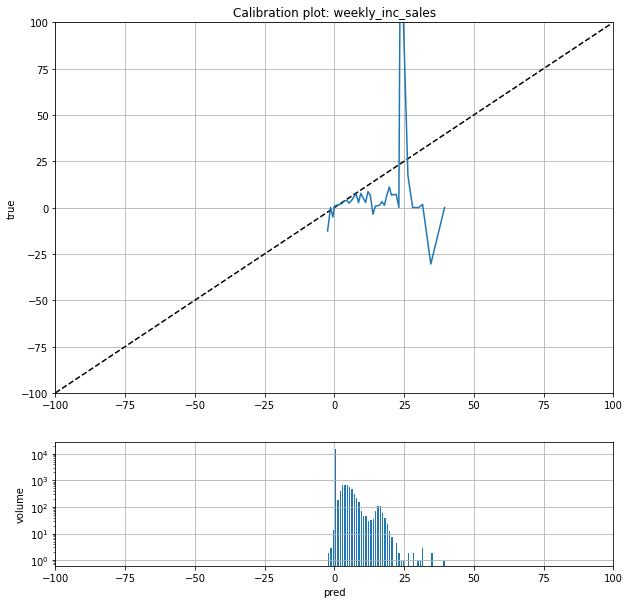

In [12]:
joined_df = ss1_true_df.merge(
    zic_df[['crn', 'ref_dt', 'score']], how = 'inner', left_on=['crn', 'ref_dt'], right_on=['crn', 'ref_dt']
).merge(
    zir_df[['crn', 'ref_dt', 'score']], how = 'inner', left_on=['crn', 'ref_dt'], right_on=['crn', 'ref_dt']
)

def combine_score(row):
    if row['score_x'] <= threshold:
        return 0
    else:
        return row['score_y']

joined_df['score'] = joined_df.apply(combine_score, axis=1)
joined_df.rename(columns={'weekly_inc_sales': 'target', 'score': 'pred'}, inplace=True)

calplot(joined_df, 'Calibration plot: weekly_inc_sales', 50, limit=100)

In [13]:
y_true = joined_df['target'].values
y_pred = joined_df['pred'].values

rmse = np.sqrt(((y_true - y_pred) ** 2).mean())
print(f'RMSE = {rmse}')
print(f'Pearson R = {stats.pearsonr(y_true, y_pred)}')

RMSE = 18.783963677238706
Pearson R = (0.05089670022354147, 4.5380996661978386e-14)


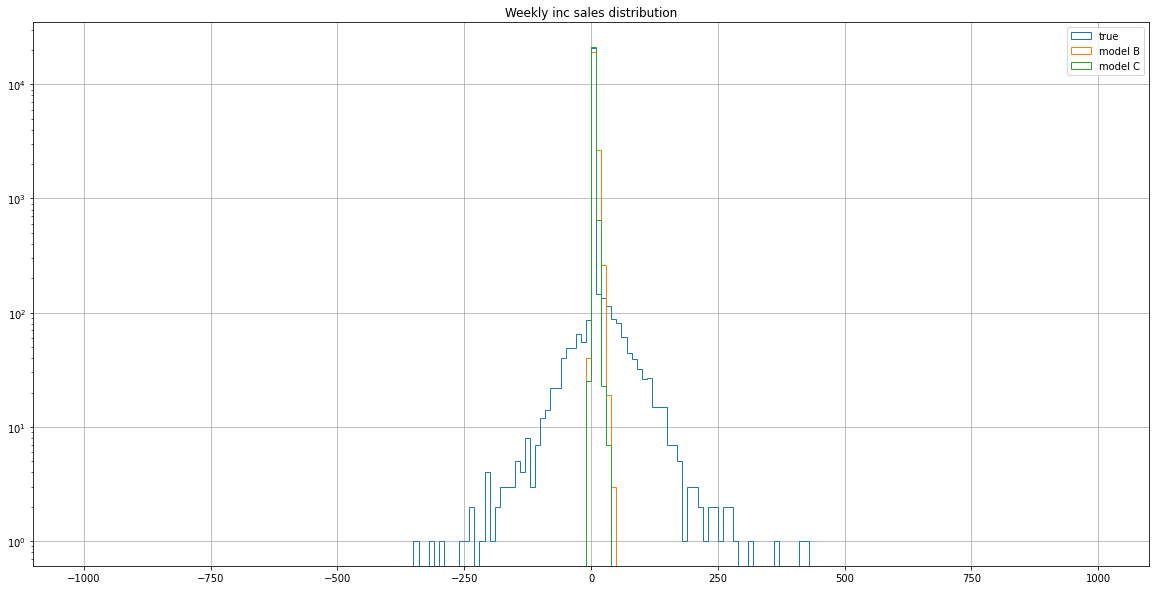

In [15]:
bins = 200
plt.figure(figsize=(20,10))
plt.hist(y_true, bins=bins, range=(-1000, 1000), histtype='step', label='true')
plt.hist(y_pred_new, bins=bins, range=(-1000, 1000), histtype='step', label='model B')
plt.hist(y_pred, bins=bins, range=(-1000, 1000), histtype='step', label='model C')
plt.title("Weekly inc sales distribution")
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

### Base Spend

In [23]:
sql = '''
    WITH wkly_base_spd AS (
        SELECT 
            crn, 
            campaign_start_date, 
            fw_start_date, 
            SUM(control_spend) AS wkly_control_spend
        FROM `wx-bq-poc.Attribution_Safari_Matching.safari_store`
        WHERE 1=1
            AND campaign_start_date BETWEEN '2021-06-21' AND '2021-08-02'
            AND campaign_code = 'CVM-3525'
        GROUP BY 1,2,3
    )
    SELECT 
        crn, 
        DATE_ADD(campaign_start_date, INTERVAL -15 DAY) AS ref_dt,
        AVG(wkly_control_spend) AS avg_wkly_control_spend
    FROM wkly_base_spd
    GROUP BY 1,2
'''

safari_df = util.sql2df(PROJECT, sql)
mmm_df = util.pq2df('gs://wx-personal/denny/direct_inc_sales_model/base_SS1_old/scoring/output/2021-09-09/processed_data')

mmm_df = mmm_df[['crn', 'ref_dt', 'score']]
mmm_df.rename(columns={'score': 'mmm_pred'}, inplace=True)
safari_df.rename(columns={'avg_wkly_control_spend': 'safari_pred'}, inplace=True)
safari_df.safari_pred =  safari_df.safari_pred.astype('float64')

mmm_safari_df = mmm_df.merge(safari_df, left_on=['crn', 'ref_dt'], right_on=['crn', 'ref_dt'])

Average base spend: 	MMM = 40.3736140609047; 	Safari = 9.629278565515019
RMSE = 47.95384675089484
Pearson R = (0.31728282614705205, 0.0)


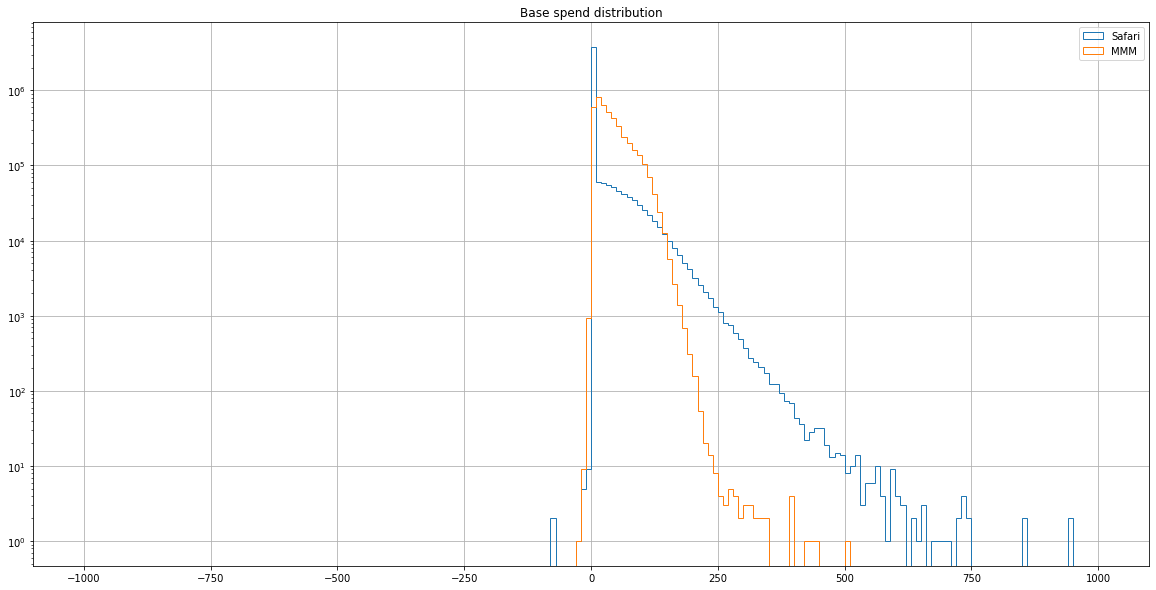

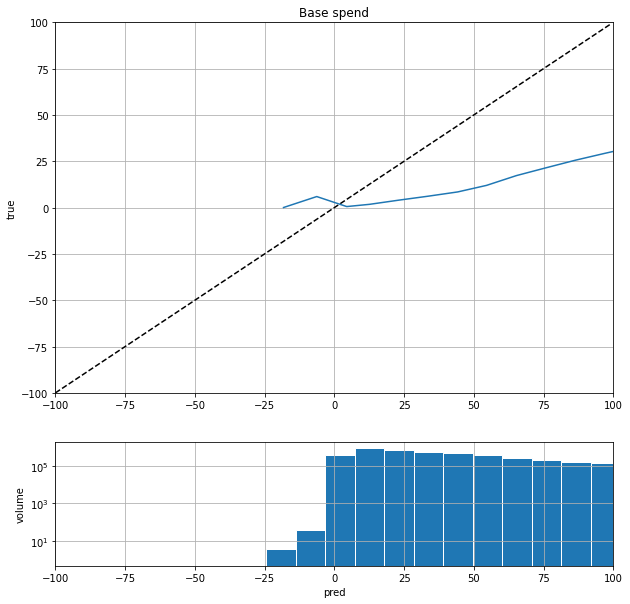

In [46]:
rmse = np.sqrt(((mmm_safari_df.safari_pred - mmm_safari_df.mmm_pred) ** 2).mean())
print(f'Average base spend: \tMMM = {mmm_safari_df.mmm_pred.mean()}; \tSafari = {mmm_safari_df.safari_pred.mean()}')
print(f'RMSE = {rmse}')
print(f'Pearson R = {stats.pearsonr(mmm_safari_df.safari_pred, mmm_safari_df.mmm_pred)}')

bins = 200
plt.figure(figsize=(20,10))
plt.hist(mmm_safari_df.safari_pred, bins=bins, range=(-1000, 1000), histtype='step', label='Safari')
plt.hist(mmm_safari_df.mmm_pred, bins=bins, range=(-1000, 1000), histtype='step', label='MMM')
plt.title("Base spend distribution")
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

mmm_safari_df['pred'] = mmm_safari_df.mmm_pred
mmm_safari_df['target'] = mmm_safari_df.safari_pred
calplot(mmm_safari_df, 'Base spend', 50, limit=100)